## Global Black Box Optimization with RNNS

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
print(tf.__version__)

1.1.0


In [2]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernel(x,X)
    return 2*(np.squeeze(np.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return 2*(tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

In [3]:
def gen_data(n_train, n_test, n_gp_samples = 8):
    
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples, 2))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))

    # Compute and invert the GP Kernel Matrix
    K_XX = kernel(X,X)
    A = np.linalg.inv(K_XX)
    A = np.matmul(A,np.expand_dims(Y,axis=2))
    
    # Compute min and max
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)

    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
    y = GP(X,A,x,minv = -1.0, maxv = 1.0)
    
    min_val = np.min(y,1).reshape(-1,1)
    max_val = np.max(y,1).reshape(-1,1)
    
    Y = 2*(Y-min_val)/(max_val-min_val)-1
    
    return (X, Y, A, min_val, max_val)

In [4]:
n_train = 16
n_test = 16
n_gp_samples = 8

X, Y, A, min_val, max_val = gen_data(n_train, n_test, n_gp_samples=8)

print(X.shape)
print(Y.shape)
print(A.shape)
print(min_val.shape)
print(max_val.shape)

X_train, Y_train, A_train, min_train, max_train = \
    X[:n_train], Y[:n_train], A[:n_train], min_val[:n_train], max_val[:n_train]

X_test, Y_test, A_test, min_test, max_test = \
    X[-n_test:], Y[-n_test:], A[-n_test:], min_val[-n_test:], max_val[-n_test:]

(32, 8, 2)
(32, 8)
(32, 8, 1)
(32, 1)
(32, 1)


In [5]:
# Data for Plotting
xx1 = np.linspace(-1,1,100)
xx2 = np.linspace(-1,1,100)
x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)
XX1, XX2 = np.meshgrid(xx1,xx2)
y = GP(X,A,x,min_val, max_val)

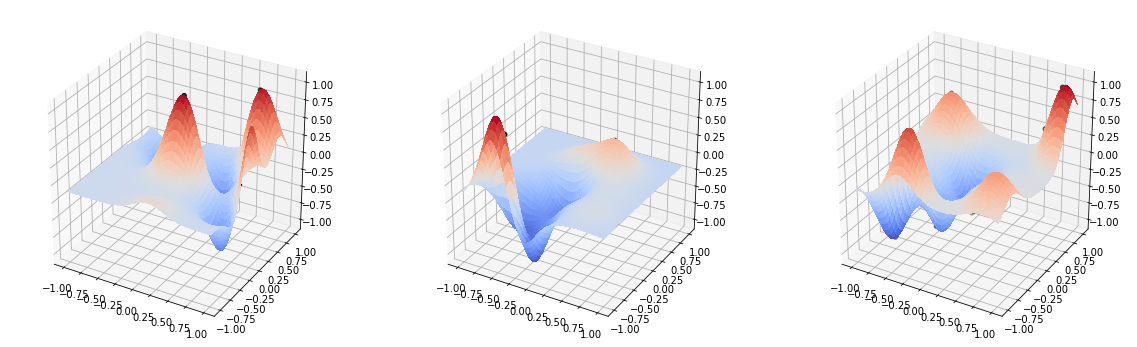

In [6]:
fig = plt.figure(figsize=(20,6))

for i in range(3):
    ax1 = fig.add_subplot(1,3,1+i, projection='3d')
    ax1.plot_surface(XX1, XX2, y[i].reshape(100,100), cmap=cm.coolwarm, 
                           linewidth=0, antialiased=False)
    ax1.scatter3D(X[i,:,1], X[i,:,0], Y[i,:], color = "k")
plt.show()

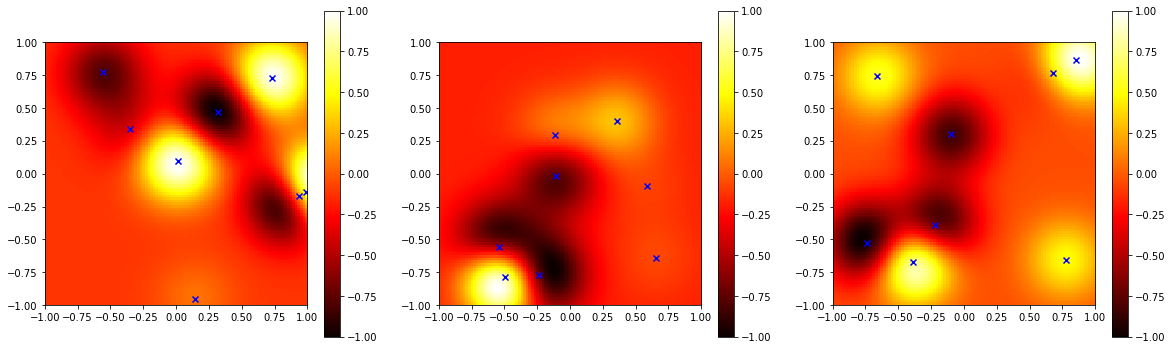

In [7]:
plt.figure(figsize=(20,6))
for i in range(3):
    plt.subplot(1,3,1+i)
    plt.imshow(y[i].reshape(100,100), cmap='hot', interpolation='nearest', extent=[-1,1,1,-1])
    plt.colorbar()
    plt.scatter(X[i,:,1], X[i,:,0], color = "b", marker = "x")
    plt.xlim([-1,1])
    plt.ylim([-1,1])
plt.show()

In [8]:
# Number of hidden states in RNN cell
n_hidden = 50

# Sequence length
num_steps = 10

In [9]:
# Create RNN Cell
# x, h = RNN(x, y, h)

variable_dict = {"W1": tf.Variable(tf.truncated_normal([2 + 1 + n_hidden, 100],stddev=0.01), name="W1"),\
                  "b1": tf.Variable(tf.zeros([100]), name="b1"),\
                  "W2": tf.Variable(tf.truncated_normal([100, n_hidden],stddev=0.01), name="W2"),\
                  "b2": tf.Variable(tf.zeros([n_hidden]), name="b2"),\
                  "Wx": tf.Variable(tf.truncated_normal([n_hidden, 2],stddev=0.01), name="Wx"),\
                  "bx": tf.Variable(tf.zeros([2]), name="bx")}

def rnn_cell(x, y, h, v_dict):
    h = tf.tanh(tf.matmul(tf.tanh(tf.matmul(tf.concat([x, y, h], 1),\
                                       v_dict["W1"]) + v_dict["b1"]), v_dict["W2"]) + v_dict["b2"])
    
    #return tf.split(z,[1, n_hidden],axis=1)
    x = tf.tanh(tf.matmul(h, v_dict["Wx"]) + v_dict["bx"])
        
    return (x, h) 

In [10]:
# Create Model

size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_gp_samples, 2])
At = tf.placeholder(tf.float32, [None, n_gp_samples, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, 2])
h_0 = tf.ones([size, n_hidden])#tf.truncated_normal([size, n_hidden],stddev=0.1)

h = h_0
x = x_0
y = GPTF(Xt,At,x, mint, maxt)
sample_points = [x]

f_min = y
f_sum = 0
for i in range(num_steps):
    
    x, h = rnn_cell(x, y, h, variable_dict)
    #x += dx
    sample_points.append(x)
    y = GPTF(Xt,At,x, mint, maxt)
    f_min = tf.minimum(y, f_min)
    
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = (f_sum) / num_steps

In [11]:
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
#train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []

In [13]:
# Train the Network
epochs = 3000
batch_size = n_train

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
        A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
        min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
        max_batch = max_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={Xt: X_batch, At: A_batch, size: batch_size, mint: min_batch, maxt: max_batch})
    
    train_loss_list += [sess.run([loss], feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})]
    train_fmin_list += [sess.run([f_min], feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})]
    test_loss_list += [sess.run([loss], feed_dict={Xt: X_test, At: A_test, size:n_test, mint: min_test, maxt: max_test})]
    
    if ep % (epochs // 10) == 0 or ep == epochs-1:
        print("Epoch: " +str(ep)+" Training loss: "+str(train_loss_list[-1])\
              +"Minimum f value: "+ str(train_fmin_list[-1])+ " Test loss: "+str(test_loss_list[-1]))

Epoch: 0 Training loss: [0.045456115]Minimum f value: [0.045058299] Test loss: [-0.0069365292]
Epoch: 300 Training loss: [-0.2108008]Minimum f value: [-0.3171289] Test loss: [-0.037387837]
Epoch: 600 Training loss: [-0.21094127]Minimum f value: [-0.31388187] Test loss: [-0.036536593]
Epoch: 900 Training loss: [-0.21102226]Minimum f value: [-0.31253076] Test loss: [-0.036006249]
Epoch: 1200 Training loss: [-0.21107391]Minimum f value: [-0.31138515] Test loss: [-0.035616484]
Epoch: 1500 Training loss: [-0.21111175]Minimum f value: [-0.31030533] Test loss: [-0.035298359]
Epoch: 1800 Training loss: [-0.21114703]Minimum f value: [-0.30919442] Test loss: [-0.034998812]
Epoch: 2100 Training loss: [-0.21119848]Minimum f value: [-0.30888775] Test loss: [-0.034650713]
Epoch: 2400 Training loss: [-0.21135947]Minimum f value: [-0.31146982] Test loss: [-0.034029573]
Epoch: 2700 Training loss: [-0.28686208]Minimum f value: [-0.4688518] Test loss: [-0.10262258]
Epoch: 2999 Training loss: [-0.38094765

In [14]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train, 2).transpose((1,0,2))
samples_test = sess.run([sample_points], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test, 2).transpose((1,0,2))

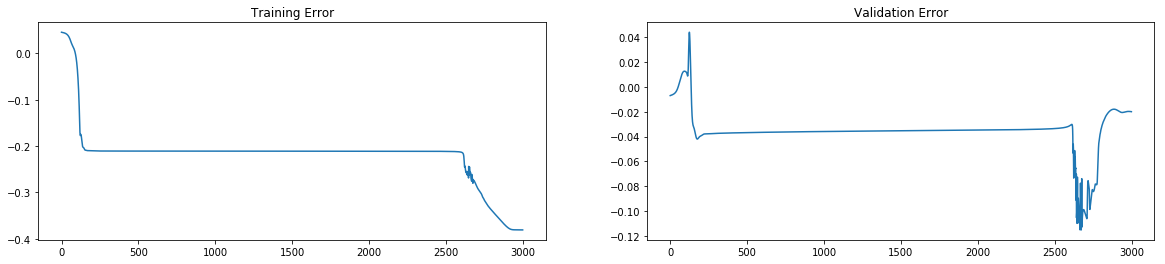

In [15]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(1,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.show()

In [16]:
def plot_result(traintest = "train"):
    if traintest == "train":
        X, A, minv, maxv = (X_train, A_train, min_train, max_train)
        samples = samples_train
        i = np.random.randint(n_train)
    else:
        X, A, minv, maxv  = (X_test, A_test, min_test, max_test)
        samples = samples_test
        i = np.random.randint(n_test)
        
    # Data for Plotting
    xx1 = np.linspace(-1,1,100)
    xx2 = np.linspace(-1,1,100)
    x = np.array(np.meshgrid(xx1,xx2)).T.reshape(1,-1,2)

    y = GP(X,A,x,minv, maxv, l = 0.3)
    
    plt.figure(figsize=(20,18))
    for i in range(9):
        plt.subplot(3,3,1+i)
        plt.imshow(y[i].reshape(100,100), cmap='hot', interpolation='nearest', extent=[-1,1,1,-1])
        plt.colorbar()
        plt.scatter(samples[i,:,1], samples[i,:,0], color = "b", marker = "x")
        for j in range(1+num_steps):
            plt.text(samples[i,j,1], samples[i,j,0], str(j), color="green", fontsize=12)
        plt.xlim([-1,1])
        plt.ylim([-1,1])
    plt.show()

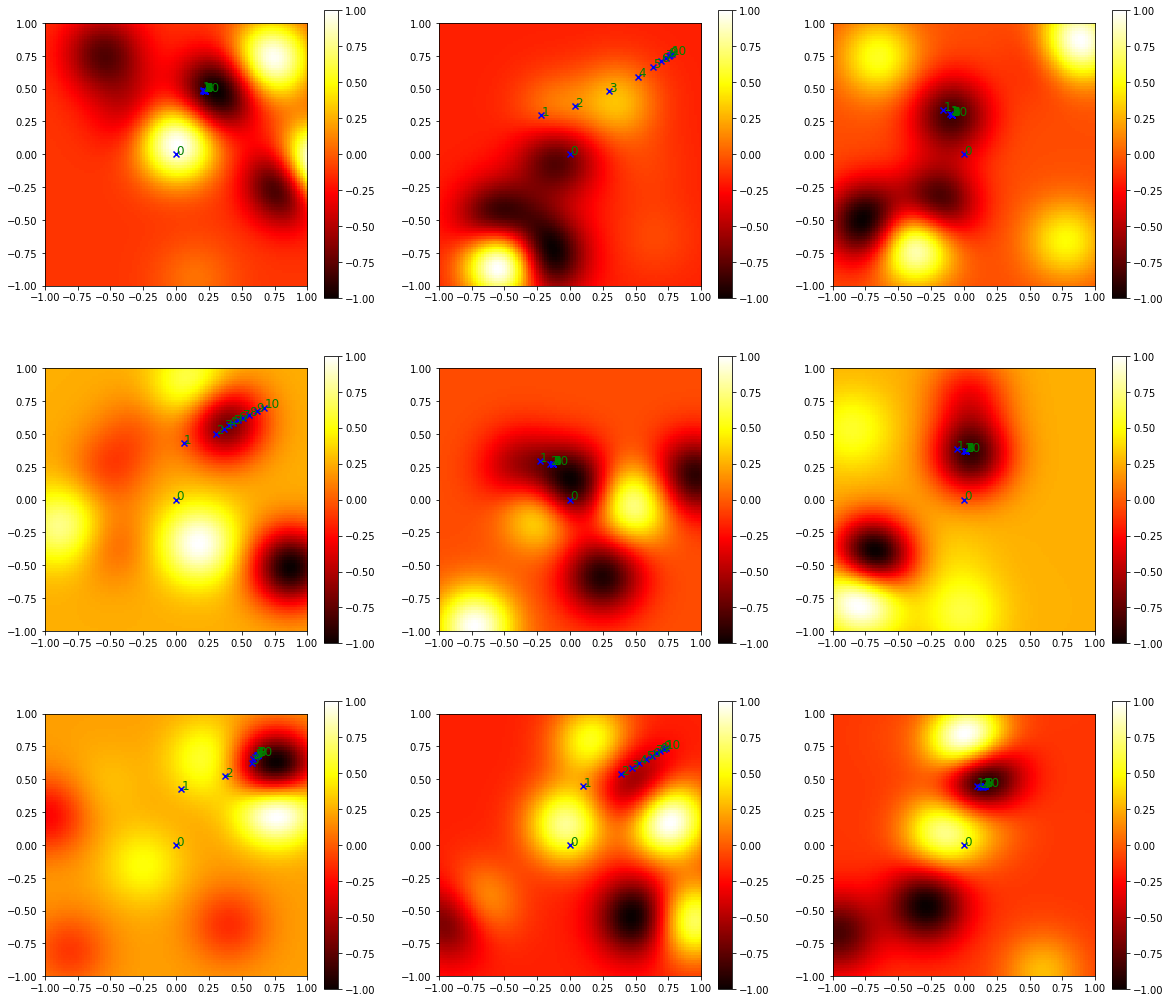

In [17]:
plot_result("train")

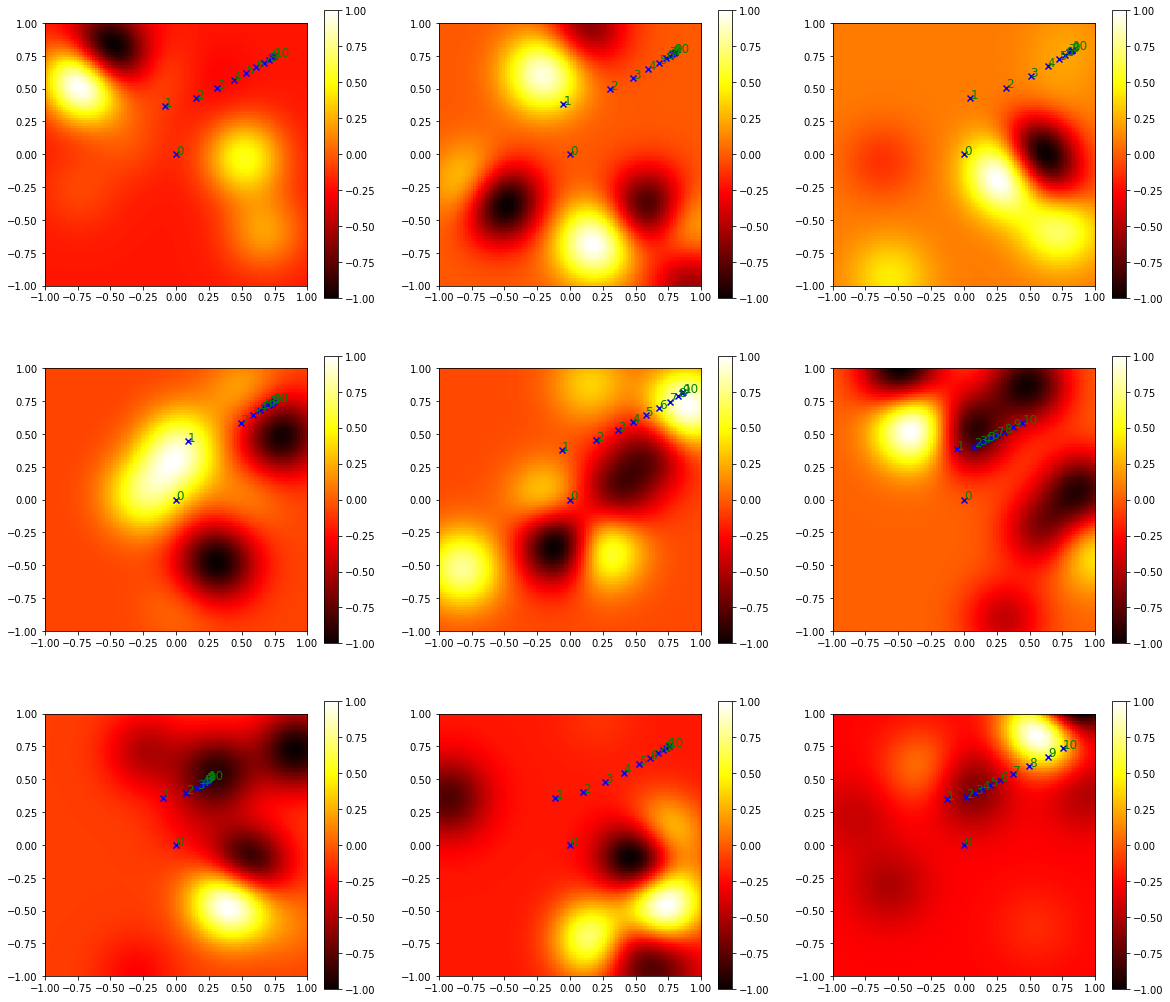

In [18]:
plot_result("test")